In [8]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from typing import Dict, List, Optional  

In [14]:
load_dotenv()
REDDIT_CONFIG = {
    'client_id': os.getenv('REDDIT_CLIENT_ID'),
    'client_secret': os.getenv('REDDIT_CLIENT_SECRET'),
    'user_agent': os.getenv('REDDIT_USER_AGENT'),
    'redirect_uri': os.getenv('REDDIT_REDIRECT_URI')
}
if all(REDDIT_CONFIG.values()):
    print("Environment variables loaded successfully!")
else:
    print("Missing environment variables. Please check your .env file!")
    missing = [k for k, v in REDDIT_CONFIG.items() if not v]
    print(f"Missing values for: {missing}")

Environment variables loaded successfully!


In [15]:
class RedditAPI:
    def __init__(self):
        self.client_id = REDDIT_CONFIG['client_id']
        self.client_secret = REDDIT_CONFIG['client_secret']
        self.user_agent = REDDIT_CONFIG['user_agent']
        self.auth = requests.auth.HTTPBasicAuth(self.client_id, self.client_secret)
        self.token = None
        self.token_expiry = 0

    def _get_token(self) -> None:
        """Get OAuth token from Reddit"""
        try:
            data = {
                'grant_type': 'client_credentials'
            }
            headers = {'User-Agent': self.user_agent}
            
            print("Attempting to authenticate...")
            response = requests.post(
                'https://www.reddit.com/api/v1/access_token',
                auth=self.auth,
                data=data,
                headers=headers
            )
            
            if response.status_code == 200:
                self.token = response.json()['access_token']
                self.token_expiry = time.time() + 3600  # Token expires in 1 hour
                print("Authentication successful!")
            else:
                print(f"Authentication failed with status code: {response.status_code}")
                print(f"Response: {response.text}")
                response.raise_for_status()
                
        except Exception as e:
            print(f"Error during authentication: {str(e)}")
            raise

    def _ensure_valid_token(self) -> None:
        if not self.token or time.time() > self.token_expiry:
            self._get_token()

    def get_subreddit_posts(self, subreddit: str, limit: int = 25) -> List[Dict]:
        """Get posts from a subreddit"""
        self._ensure_valid_token()
        
        headers = {
            'User-Agent': self.user_agent,
            'Authorization': f'Bearer {self.token}'
        }
        
        params = {
            'limit': min(limit, 100)
        }
        
        response = requests.get(
            f'https://oauth.reddit.com/r/{subreddit}/hot',
            headers=headers,
            params=params
        )
        
        if response.status_code == 200:
            return [post['data'] for post in response.json()['data']['children']]
        else:
            print(f"Error fetching posts: {response.status_code}")
            print(f"Response: {response.text}")
            response.raise_for_status()

In [16]:
reddit = RedditAPI()

In [22]:
posts = reddit.get_subreddit_posts('tech', limit=5)
posts_df = pd.DataFrame(posts)
posts_df[display_columns].head()

,title,score,num_comments
0,"Finland’s 100MW sand battery turns 2,000 tons ...",531,27
1,New Twitch policy bans the word ‘Zionist’ amid...,74,41
2,Wave-busting tech from Edinburgh keeps robots ...,83,0
3,Fatbergs fighter: New self-healing zinc coatin...,1098,34
4,New microreactor converts CO2 to methanol with...,520,18


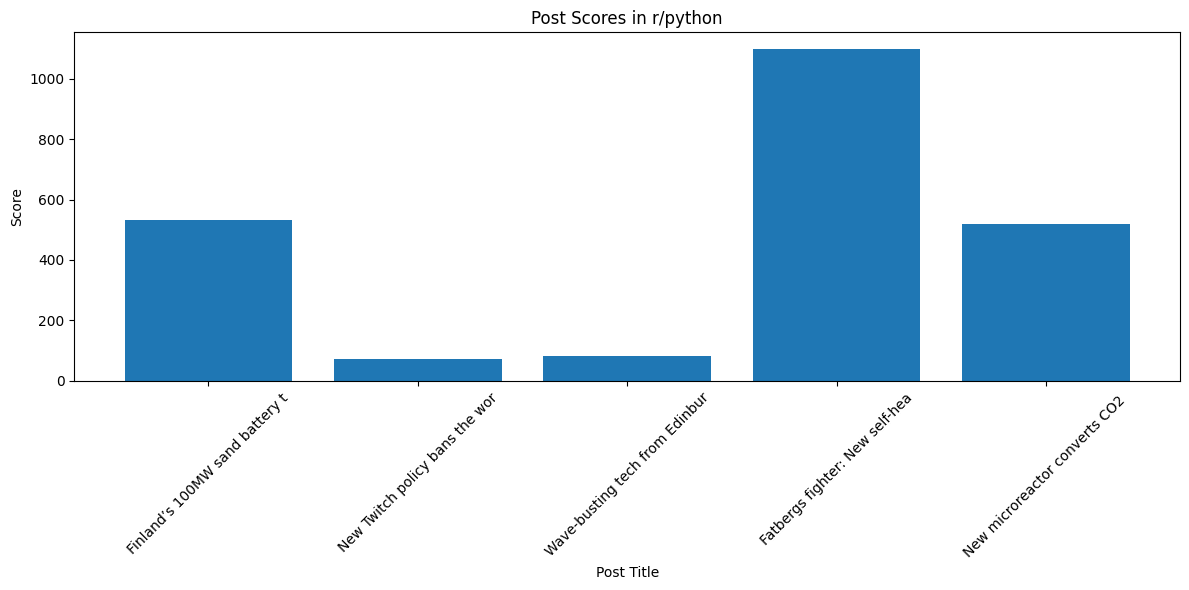

In [23]:
plt.figure(figsize=(12, 6))
plt.bar(posts_df['title'].str[:30], posts_df['score'])
plt.xticks(rotation=45)
plt.title('Post Scores in r/python')
plt.xlabel('Post Title')
plt.ylabel('Score')
plt.tight_layout()
plt.show()